In [1]:
# === Shared setup (run once at top) ===
from pathlib import Path
import pandas as pd, numpy as np, cv2, os, random, time

ROOT    = Path(r"C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection")
RAW_DIR = ROOT / "data" / "raw_images"          # has 0..9 subfolders
WORK    = ROOT / "workspace"
CROPS_DIR = WORK / "crops_128"                   # normalized crops saved here
SPLITS  = WORK / "splits"
MODELS  = ROOT / "models"
IMG_SIZE = (128,128)                             # (W,H)
RNG_SEED = 42

for d in [WORK, CROPS_DIR, SPLITS, MODELS]: d.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)


ROOT: C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection


In [2]:
import os, cv2, json, shutil, numpy as np, pandas as pd
from pathlib import Path

C:\Users\sayu\AppData\Local\Temp\ipykernel_16368\2474761701.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_counts.index.astype(str), y=class_counts.values, palette="tab10")


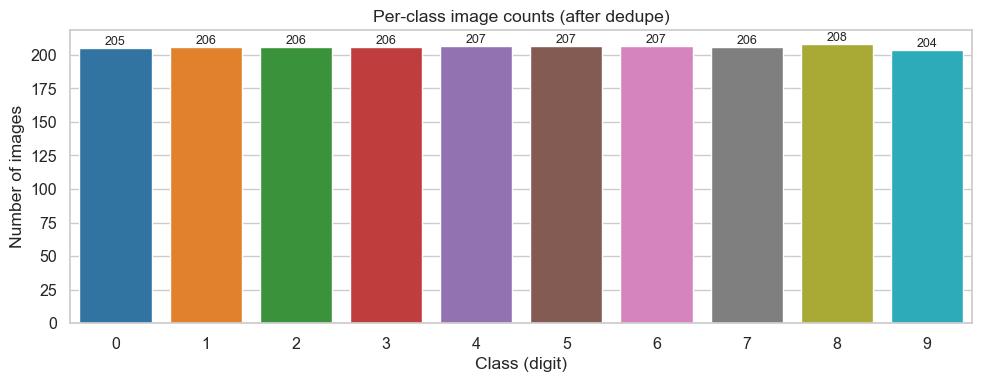

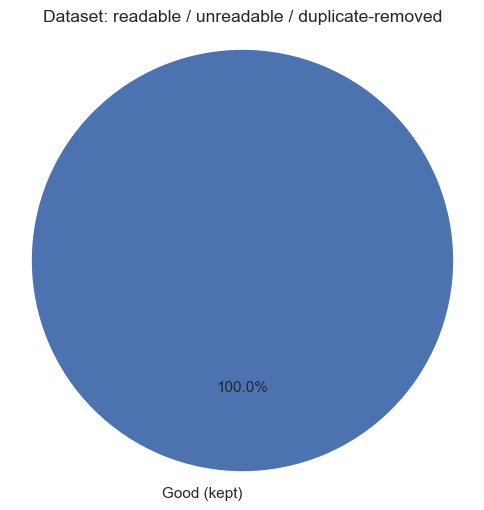

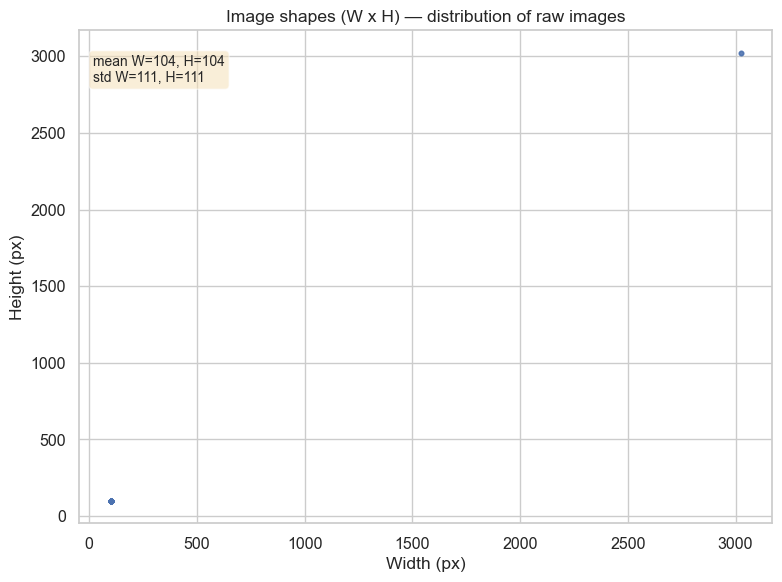

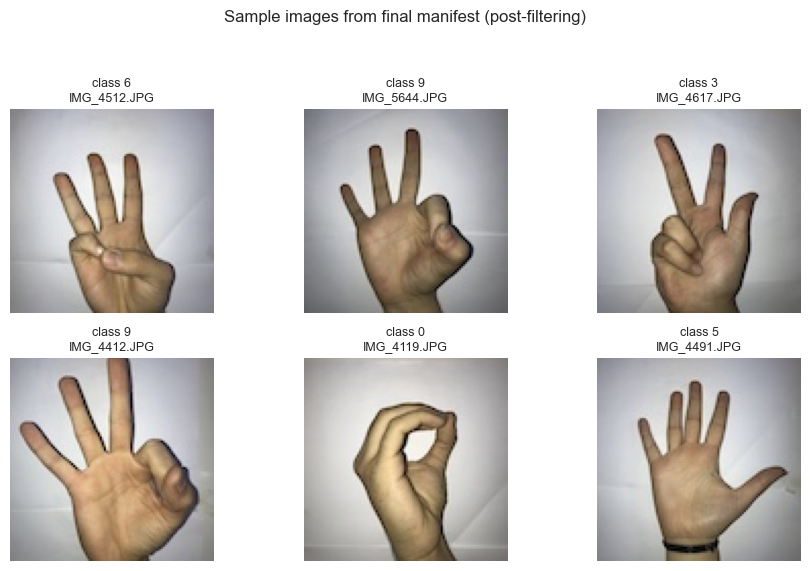

SUMMARY:
  Raw discovered files: 43
  Readable (kept before dedupe): 2062
  Unreadable (bad): 0
  Deduped: 2062 -> 2062 (removed 0 duplicates)
  Final manifest entries: 2062
  Per-class counts (after dedupe):
cls
0    205
1    206
2    206
3    206
4    207
5    207
6    207
7    206
8    208
9    204


In [46]:
#member 1
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import cv2
import random

sns.set(style="whitegrid", font_scale=1.05)

# --- gather safe counts and stats (works with variables from Member-1) ---
total_raw = len(rows)                 # original discovered files
num_bad   = len(bad)                  # unreadable files list collected earlier
num_after = len(manifest)             # final (good + deduped) manifest
num_dedup_removed = total_raw - before
num_removed_by_bad = before - len(rows) if 'before' in globals() else num_bad

# per-class counts (manifest is final list after dedupe)
class_counts = manifest['cls'].value_counts().sort_index()

# image shapes array (list of (h,w))
shapes_arr = np.array(shapes) if len(shapes)>0 else np.empty((0,2))

# --- 1) Per-class counts bar chart ---
plt.figure(figsize=(10,4))
ax = sns.barplot(x=class_counts.index.astype(str), y=class_counts.values, palette="tab10")
ax.set_title("Per-class image counts (after dedupe)")
ax.set_xlabel("Class (digit)")
ax.set_ylabel("Number of images")
for i,p in enumerate(ax.patches):
    ax.annotate(f"{int(p.get_height())}", (p.get_x()+p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()


# --- 2) Pie chart: good vs bad vs removed-by-dedup ---
labels = []
sizes = []
labels.append("Good (kept)")
sizes.append(num_after)
if num_bad>0:
    labels.append("Unreadable")
    sizes.append(num_bad)
# if dedup removed (before->after)
dedup_removed = before - num_after
if dedup_removed>0:
    labels.append("Removed (dupes)")
    sizes.append(dedup_removed)

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90, textprops={'fontsize':11})
plt.title("Dataset: readable / unreadable / duplicate-removed")
plt.axis('equal')
plt.show()


# --- 3) Image shape scatter + marginals ---
if shapes_arr.shape[0] > 0:
    h = shapes_arr[:,0]; w = shapes_arr[:,1]
    plt.figure(figsize=(8,6))
    plt.scatter(w, h, alpha=0.5, s=10)
    plt.xlabel("Width (px)")
    plt.ylabel("Height (px)")
    plt.title("Image shapes (W x H) — distribution of raw images")
    # simple mean/std annotation
    plt.gca().annotate(f"mean W={w.mean():.0f}, H={h.mean():.0f}\nstd W={w.std():.0f}, H={h.std():.0f}",
                       xy=(0.02,0.95), xycoords='axes fraction', va='top', fontsize=10,
                       bbox=dict(boxstyle="round", fc="wheat", alpha=0.5))
    plt.tight_layout()
    plt.show()
else:
    print("No shape data collected (shapes list empty).")


# --- 4) Small grid of example images from final manifest ---
def show_examples(n=9, seed=RNG_SEED):
    rng = random.Random(seed)
    sample_rows = manifest.sample(n=min(n, len(manifest)), random_state=seed).to_dict('records')
    cols = min(3, len(sample_rows))
    rows_grid = (len(sample_rows)+cols-1)//cols
    plt.figure(figsize=(3*cols, 3*rows_grid))
    for i, r in enumerate(sample_rows):
        p, cls = r['path'], r['cls']
        img = cv2.imread(p)
        if img is None:
            img = np.zeros((128,128,3), dtype=np.uint8)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax = plt.subplot(rows_grid, cols, i+1)
        plt.imshow(img_rgb)
        plt.title(f"class {cls}\n{Path(p).name}", fontsize=9)
        plt.axis('off')
    plt.suptitle("Sample images from final manifest (post-filtering)", fontsize=12)
    plt.tight_layout(rect=[0,0.03,1,0.95])
    plt.show()

show_examples(n=6, seed=RNG_SEED)


# --- Summary prints for quick reference ---
print("SUMMARY:")
print(f"  Raw discovered files: {total_raw}")
print(f"  Readable (kept before dedupe): {before}") 
print(f"  Unreadable (bad): {num_bad}")
print(f"  Deduped: {before} -> {num_after} (removed {dedup_removed} duplicates)")
print(f"  Final manifest entries: {num_after}")
print("  Per-class counts (after dedupe):")
print(class_counts.to_string())


In [4]:
#member 2
import mediapipe as mp
mp_hands = mp.solutions.hands.Hands(static_image_mode=True,
                                    max_num_hands=1,
                                    min_detection_confidence=0.5)

def detect_bbox_norm(bgr):
    # returns (x1n,y1n,x2n,y2n) in [0,1] or None if not found
    import numpy as np, cv2
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    res = mp_hands.process(rgb)
    if not res.multi_hand_landmarks:
        return None
    lms = res.multi_hand_landmarks[0].landmark
    xs = [lm.x for lm in lms]; ys = [lm.y for lm in lms]
    return float(min(xs)), float(min(ys)), float(max(xs)), float(max(ys))

rows, miss = [], 0
for _, r in manifest.iterrows():
    bgr = cv2.imread(r.path)
    bb  = detect_bbox_norm(bgr)
    if bb is None:
        miss += 1
    else:
        rows.append(dict(path=r.path, cls=int(r.cls),
                         x1n=bb[0], y1n=bb[1], x2n=bb[2], y2n=bb[3]))
bboxes_df = pd.DataFrame(rows)
bboxes_csv = WORK/"bboxes_auto.csv"
bboxes_df.to_csv(bboxes_csv, index=False)

print(f"Auto-boxes saved → {bboxes_csv}")
print(f"Detected: {len(bboxes_df)}  |  Misses: {miss}  ({miss/(len(manifest)+1e-9):.1%})")


C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Auto-boxes saved → C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection\workspace\bboxes_auto.csv
Detected: 1717  |  Misses: 345  (16.7%)


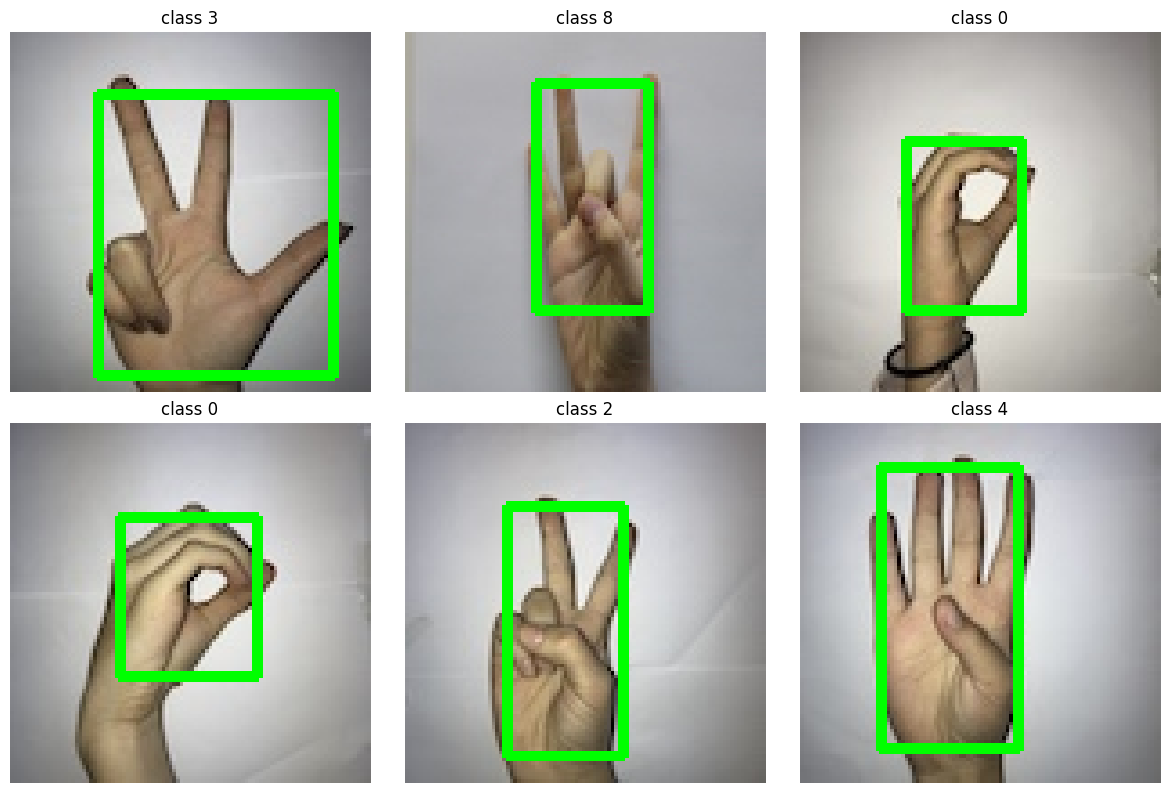

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sample = bboxes_df.sample(6, random_state=RNG_SEED)
plt.figure(figsize=(12,8))
for i,(_,row) in enumerate(sample.iterrows(),1):
    img = cv2.imread(row.path)
    h,w = img.shape[:2]
    x1,y1,x2,y2 = int(row.x1n*w), int(row.y1n*h), int(row.x2n*w), int(row.y2n*h)
    cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),2)
    plt.subplot(2,3,i); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.title(f"class {row.cls}")
plt.tight_layout(); plt.show()


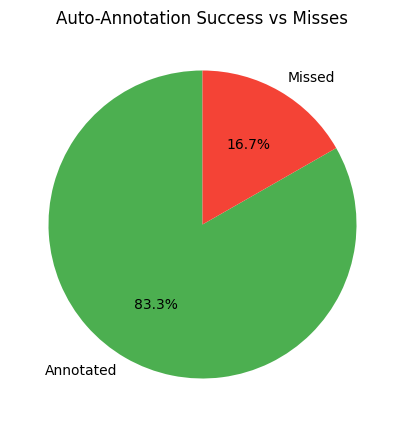

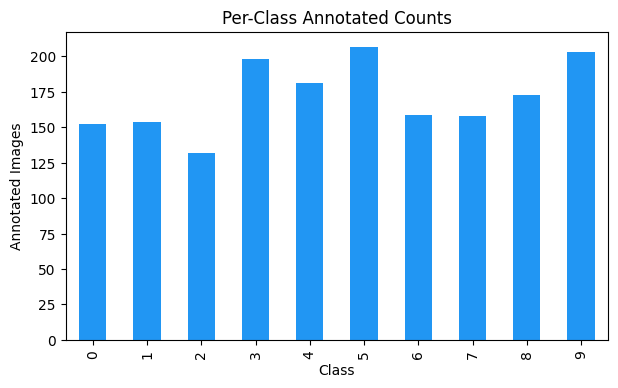

In [6]:
import matplotlib.pyplot as plt

# Plot annotation success vs misses
labels = ["Annotated", "Missed"]
counts = [len(bboxes_df), miss]
colors = ["#4CAF50", "#F44336"]

plt.figure(figsize=(5,5))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title("Auto-Annotation Success vs Misses")
plt.show()

# Also show per-class annotated count
plt.figure(figsize=(7,4))
bboxes_df.groupby("cls").size().plot(kind="bar", color="#2196F3")
plt.xlabel("Class")
plt.ylabel("Annotated Images")
plt.title("Per-Class Annotated Counts")
plt.show()


In [7]:
# member 3---Square crop + letterbox (to 128x128) ---
import numpy as np, cv2
from pathlib import Path

def make_square_bbox_px(x1,y1,x2,y2, W,H, extra=0.20):
    # coords are normalized [0,1] → pixels
    x1, y1, x2, y2 = int(x1*W), int(y1*H), int(x2*W), int(y2*H)
    cx, cy = (x1+x2)//2, (y1+y2)//2
    side = int(max(x2-x1, y2-y1) * (1.0 + extra))
    x1s = max(0, cx - side//2); y1s = max(0, cy - side//2)
    x2s = min(W, x1s + side);   y2s = min(H, y1s + side)
    if x2s - x1s < side: x1s = max(0, x2s - side)
    if y2s - y1s < side: y1s = max(0, y2s - side)
    return x1s,y1s,x2s,y2s

def letterbox_rgb(rgb, size=(128,128)):
    tw, th = size
    h, w = rgb.shape[:2]
    scale = min(tw/w, th/h)
    nw, nh = int(round(w*scale)), int(round(h*scale))
    resized = cv2.resize(rgb, (nw, nh), interpolation=cv2.INTER_AREA)
    canvas = np.zeros((th, tw, 3), dtype=rgb.dtype)
    top, left = (th-nh)//2, (tw-nw)//2
    canvas[top:top+nh, left:left+nw] = resized
    return canvas

saved = 0
for _, r in bboxes_df.iterrows():
    p, cls = r.path, int(r.cls)
    bgr = cv2.imread(p)
    if bgr is None: continue
    H, W = bgr.shape[:2]
    x1s,y1s,x2s,y2s = make_square_bbox_px(r.x1n, r.y1n, r.x2n, r.y2n, W,H, extra=0.20)
    crop = bgr[y1s:y2s, x1s:x2s]
    if crop.size == 0: continue
    rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
    inp = letterbox_rgb(rgb, IMG_SIZE)
    out_dir = CROPS_DIR/str(cls)
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir/Path(p).name
    cv2.imwrite(str(out_path), cv2.cvtColor(inp, cv2.COLOR_RGB2BGR))
    saved += 1

print("Saved crops:", saved, "->", CROPS_DIR)


Saved crops: 1717 -> C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection\workspace\crops_128


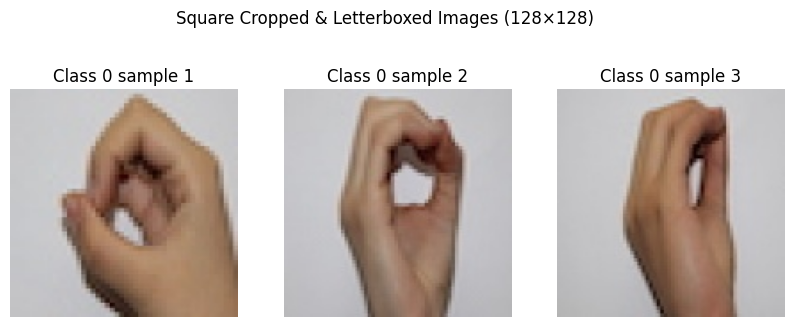

In [9]:
# Preview a few cropped+letterboxed images
import matplotlib.pyplot as plt
import random

sample_paths = list((CROPS_DIR/"0").glob("*"))[:3]  # e.g., take 3 images from class '0'
plt.figure(figsize=(10,4))
for i, p in enumerate(sample_paths, 1):
    img = cv2.cvtColor(cv2.imread(str(p)), cv2.COLOR_BGR2RGB)
    plt.subplot(1,3,i)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Class 0 sample {i}")
plt.suptitle("Square Cropped & Letterboxed Images (128×128)")
plt.show()


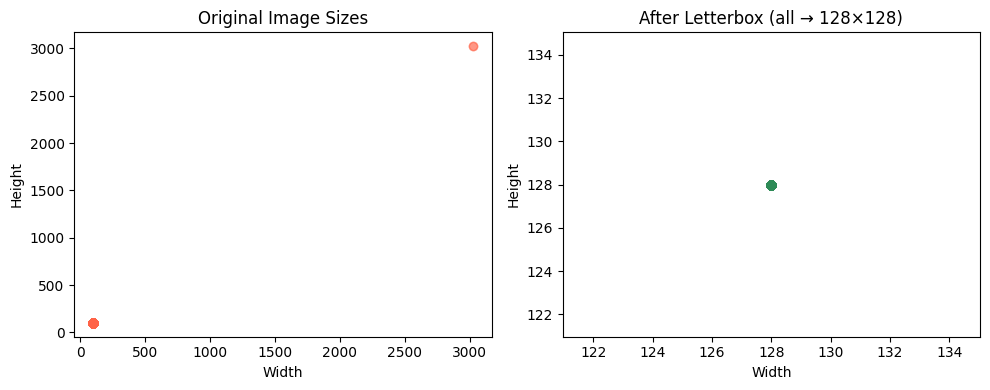

In [10]:
# Compare original sizes vs letterboxed sizes
sizes_before = [cv2.imread(r.path).shape[:2] for _, r in manifest.iterrows()]
sizes_after  = [cv2.imread(str(p)).shape[:2] for p in CROPS_DIR.rglob("*.jpg")]

h_before = [s[0] for s in sizes_before]  # heights
w_before = [s[1] for s in sizes_before]  # widths
h_after  = [s[0] for s in sizes_after]
w_after  = [s[1] for s in sizes_after]

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.scatter(w_before, h_before, alpha=0.3, color="tomato")
plt.title("Original Image Sizes")
plt.xlabel("Width"); plt.ylabel("Height")

plt.subplot(1,2,2)
plt.scatter(w_after, h_after, alpha=0.5, color="seagreen")
plt.title("After Letterbox (all → 128×128)")
plt.xlabel("Width"); plt.ylabel("Height")

plt.tight_layout()
plt.show()


In [8]:
# member 4---Quality filtering (blurry/dark) ---
import shutil

def blur_score(img_bgr):
    return cv2.Laplacian(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY), cv2.CV_64F).var()

def too_dark(img_bgr, thresh=18):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    return gray.mean() < thresh

KEEP_DIR = WORK/"crops_128_clean"
if KEEP_DIR.exists(): shutil.rmtree(KEEP_DIR)
KEEP_DIR.mkdir(parents=True, exist_ok=True)

kept, dropped = 0, 0
for cls_dir in sorted(CROPS_DIR.glob("*")):
    if not cls_dir.is_dir(): continue
    out_cls = KEEP_DIR/cls_dir.name
    out_cls.mkdir(parents=True, exist_ok=True)
    for p in cls_dir.glob("*"):
        img = cv2.imread(str(p))
        if img is None: dropped += 1; continue
        if blur_score(img) < 40 or too_dark(img):
            dropped += 1; continue
        shutil.copy2(p, out_cls/p.name)
        kept += 1

print(f"Kept {kept}, dropped {dropped}. Clean crops ->", KEEP_DIR)


Kept 1716, dropped 1. Clean crops -> C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection\workspace\crops_128_clean


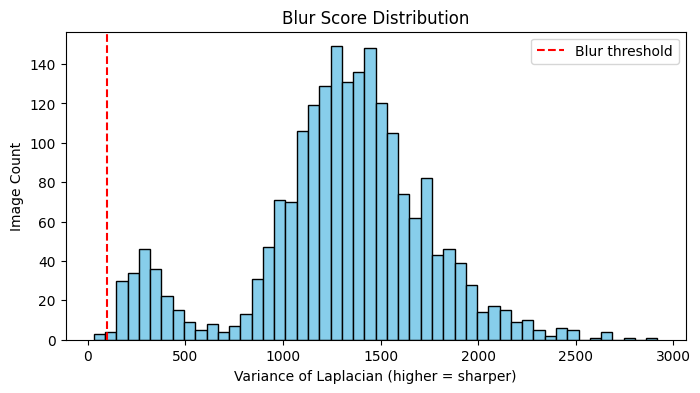

In [13]:
import cv2
import matplotlib.pyplot as plt

# Function to calculate blur score using Variance of Laplacian
def score(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

# Compute blur scores for your dataset
blur_scores = [score(cv2.imread(r.path)) for _, r in manifest.iterrows()]

# Plot histogram
plt.figure(figsize=(8,4))
plt.hist(blur_scores, bins=50, color="skyblue", edgecolor="black")
plt.axvline(100, color="red", linestyle="--", label="Blur threshold")
plt.title("Blur Score Distribution")
plt.xlabel("Variance of Laplacian (higher = sharper)")
plt.ylabel("Image Count")
plt.legend()
plt.show()


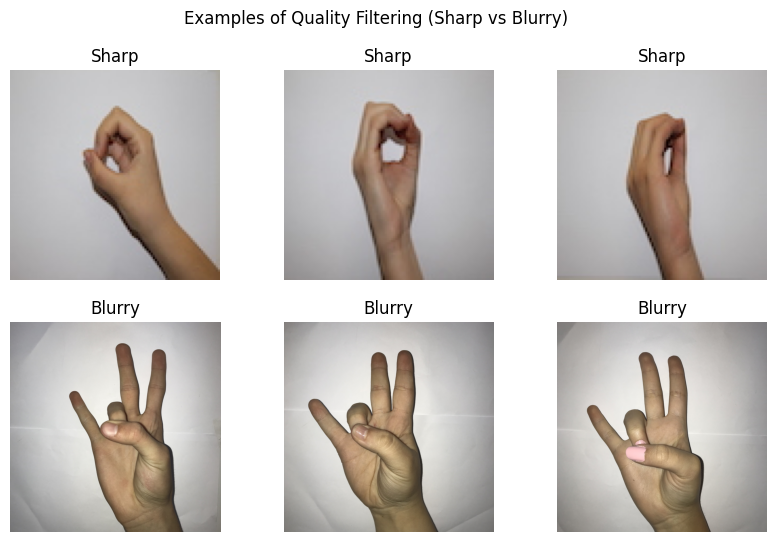

In [14]:
import random

sharp_imgs = [r.path for _, r in manifest.iterrows() if score(cv2.imread(r.path)) > 100][:3]
blurry_imgs = [r.path for _, r in manifest.iterrows() if score(cv2.imread(r.path)) <= 100][:3]

plt.figure(figsize=(10,6))

for i, p in enumerate(sharp_imgs, 1):
    img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
    plt.subplot(2,3,i)
    plt.imshow(img); plt.axis("off"); plt.title("Sharp")

for i, p in enumerate(blurry_imgs, 1):
    img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
    plt.subplot(2,3,i+3)
    plt.imshow(img); plt.axis("off"); plt.title("Blurry")

plt.suptitle("Examples of Quality Filtering (Sharp vs Blurry)")
plt.show()


In [17]:
# member 5---  Stratified train/val/test split ---
import pandas as pd
from sklearn.model_selection import train_test_split

def list_crops(root: Path):
    rows = []
    for cls_dir in sorted(root.glob("*")):
        if not cls_dir.is_dir(): continue
        cls = int(cls_dir.name)
        for p in cls_dir.glob("*"):
            rows.append(dict(path=str(p), cls=cls))
    return pd.DataFrame(rows)

clean_df = list_crops(KEEP_DIR)
print("Clean set:", len(clean_df), "Per-class:", clean_df.groupby("cls").size().to_dict())

train_df, rest_df = train_test_split(clean_df, test_size=0.20, random_state=RNG_SEED, stratify=clean_df["cls"])
val_df, test_df = train_test_split(rest_df, test_size=0.50, random_state=RNG_SEED, stratify=rest_df["cls"])

SPLITS.mkdir(parents=True, exist_ok=True)
train_df.to_csv(SPLITS/"train.csv", index=False)
val_df.to_csv(SPLITS/"val.csv", index=False)
test_df.to_csv(SPLITS/"test.csv", index=False)

print("Saved:", SPLITS)
print("Counts:", len(train_df), len(val_df), len(test_df))


Clean set: 1716 Per-class: {0: 152, 1: 154, 2: 132, 3: 198, 4: 181, 5: 207, 6: 158, 7: 158, 8: 173, 9: 203}
Saved: C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection\workspace\splits
Counts: 1372 172 172


In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# SPLITS is already defined in your setup: WORK / "splits"
train = pd.read_csv(SPLITS / "train.csv")
val   = pd.read_csv(SPLITS / "val.csv")
test  = pd.read_csv(SPLITS / "test.csv")

# keep a column telling which split each row belongs to
train["split"] = "train"
val["split"]   = "val"
test["split"]  = "test"

splits_df = pd.concat([train, val, test], ignore_index=True)
splits_df["cls"] = splits_df["cls"].astype(int)
classes = sorted(splits_df["cls"].unique())


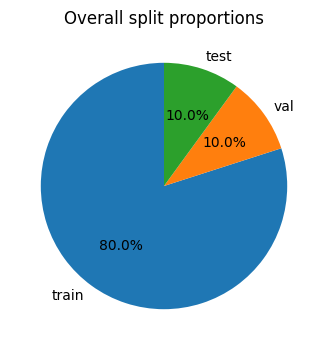

In [20]:
plt.figure(figsize=(5,4))
sizes = [len(train), len(val), len(test)]
plt.pie(sizes, labels=["train","val","test"], autopct="%1.1f%%", startangle=90)
plt.title("Overall split proportions")
plt.show()


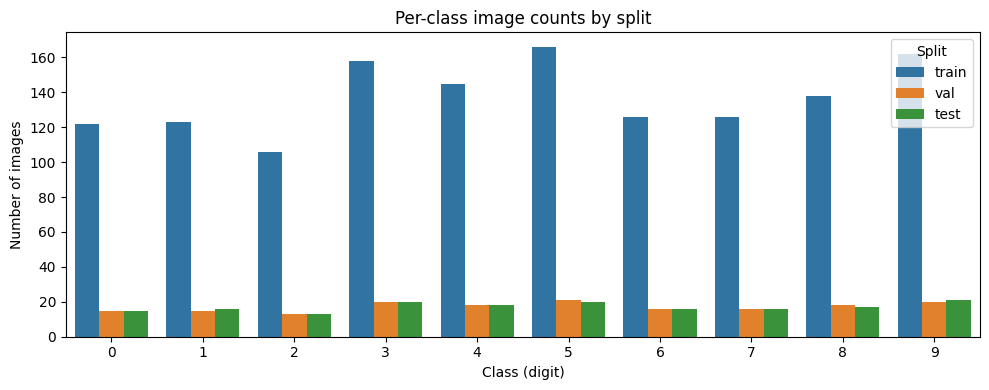

In [21]:
plt.figure(figsize=(10,4))
sns.countplot(data=splits_df, x="cls", hue="split", order=classes)
plt.title("Per-class image counts by split")
plt.xlabel("Class (digit)")
plt.ylabel("Number of images")
plt.legend(title="Split")
plt.tight_layout()
plt.show()


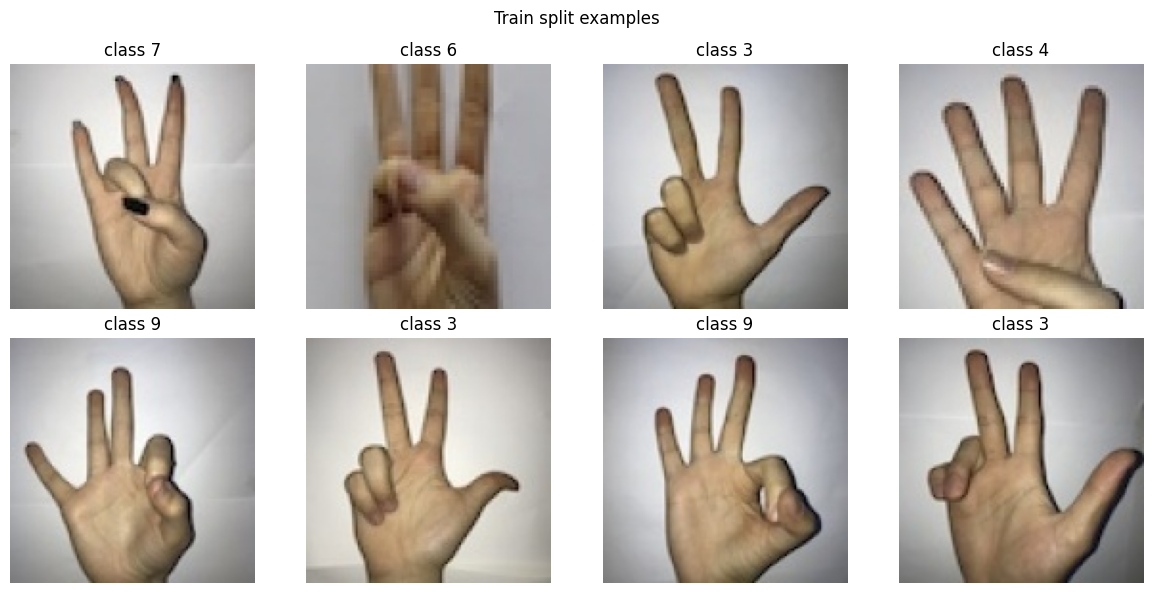

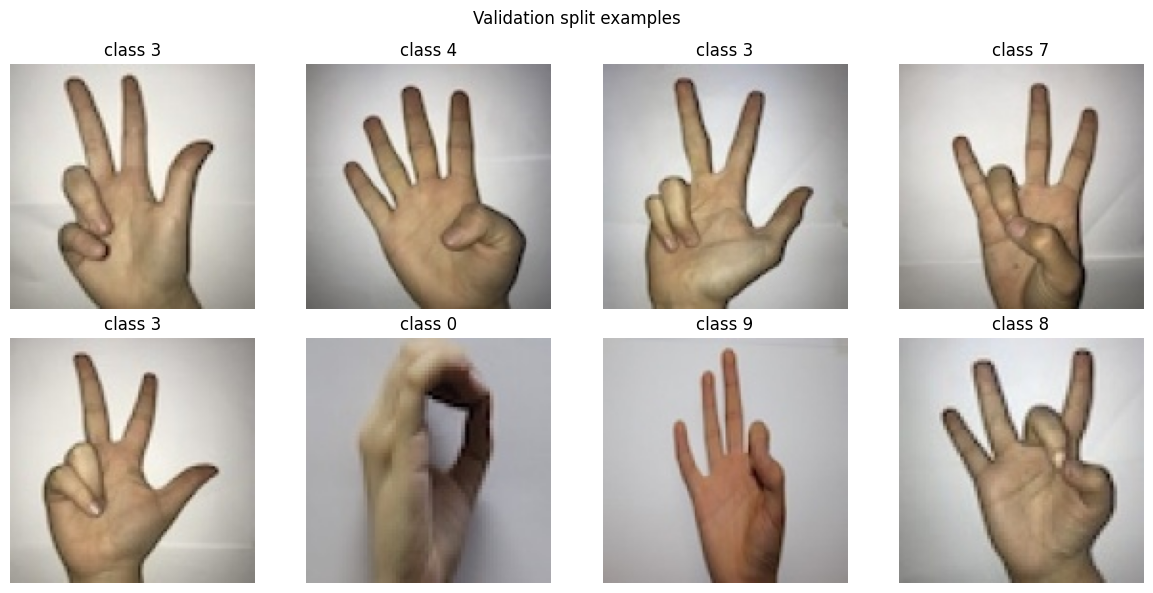

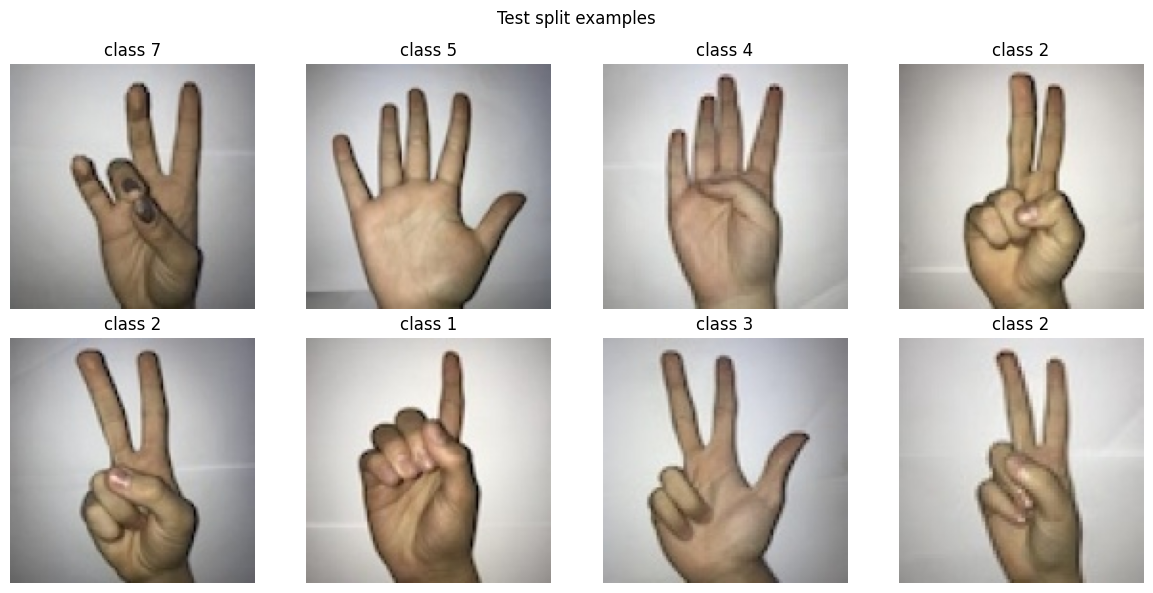

In [25]:
import cv2
from pathlib import Path

def show_examples(df, title, n=8):
    """Show n random images with class labels."""
    sample = df.sample(min(n, len(df)), random_state=42)
    cols = 4
    rows = int((len(sample) + cols - 1) // cols)
    plt.figure(figsize=(cols*3, rows*3))
    for i, (_, r) in enumerate(sample.iterrows(), 1):
        bgr = cv2.imread(r["path"])
        if bgr is None: 
            continue
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols, i)
        plt.imshow(rgb)
        plt.title(f"class {int(r['cls'])}")
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_examples(train, "Train split examples")
show_examples(val,   "Validation split examples")
show_examples(test,  "Test split examples")


Removed 0 outliers based on aspect ratio.


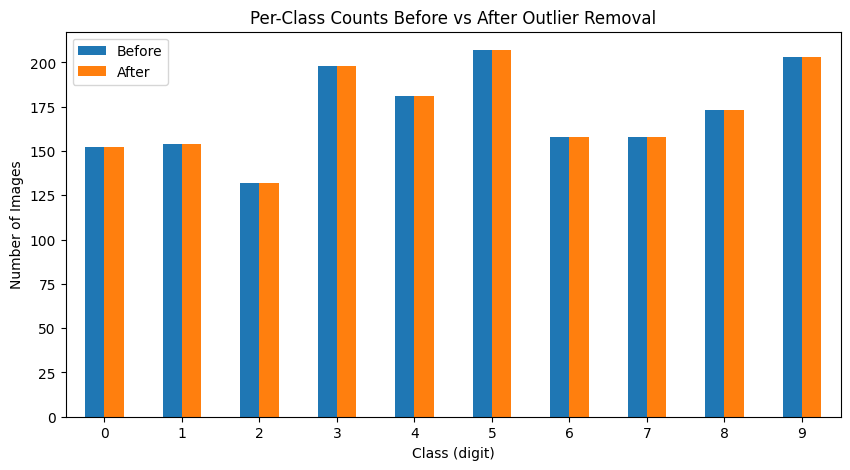

✅ Saved refined summary with outlier removal at: workspace\preprocess_summary.json


{'final_total': 1716,
 'final_split_counts': {'train': 1372, 'val': 172, 'test': 172},
 'final_per_class': {0: 152,
  1: 154,
  2: 132,
  3: 198,
  4: 181,
  5: 207,
  6: 158,
  7: 158,
  8: 173,
  9: 203}}

In [44]:
# member 6--- Outlier Removal
import os, json
import pandas as pd
import matplotlib.pyplot as plt

# Load final split CSVs
train_df = pd.read_csv(SPLITS/"train.csv")
val_df   = pd.read_csv(SPLITS/"val.csv")
test_df  = pd.read_csv(SPLITS/"test.csv")

# Merge into one clean dataframe
clean_df = pd.concat([
    train_df.assign(split="train"),
    val_df.assign(split="val"),
    test_df.assign(split="test")
], ignore_index=True)

# --- Step 1: Outlier detection by image size ---
def get_image_size(path):
    try:
        import cv2
        img = cv2.imread(path)
        if img is None: 
            return None
        return img.shape[0], img.shape[1]  # (H, W)
    except:
        return None

clean_df["size"] = clean_df["path"].apply(get_image_size)

# Drop rows where size could not be read
before_count = len(clean_df)
clean_df = clean_df.dropna(subset=["size"]).reset_index(drop=True)

# Extract aspect ratio
clean_df["aspect_ratio"] = clean_df["size"].apply(lambda s: s[1]/s[0] if s else None)

# Define outlier rule (filter extreme aspect ratios)
before_counts = clean_df['cls'].value_counts().sort_index()
clean_df = clean_df[(clean_df["aspect_ratio"] > 0.5) & (clean_df["aspect_ratio"] < 2.0)]
after_counts = clean_df['cls'].value_counts().sort_index()

print(f"Removed {before_count - len(clean_df)} outliers based on aspect ratio.")

# --- Step 2: EDA Visualization ---
df_counts = pd.DataFrame({"Before": before_counts, "After": after_counts})
df_counts.plot(kind="bar", figsize=(10,5))
plt.title("Per-Class Counts Before vs After Outlier Removal")
plt.xlabel("Class (digit)")
plt.ylabel("Number of Images")
plt.xticks(rotation=0)
plt.show()

# --- Step 3: Save Summary JSON ---
summary = {
    "final_total" : int(len(clean_df)),
    "final_split_counts" : {
        "train": int((clean_df["split"]=="train").sum()),
        "val"  : int((clean_df["split"]=="val").sum()),
        "test" : int((clean_df["split"]=="test").sum())
    },
    "final_per_class" : {int(k): int(v) for k, v in clean_df["cls"].value_counts().sort_index().to_dict().items()}
}

out_json = WORK/"preprocess_summary.json"
with open(out_json, "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2)

print("✅ Saved refined summary with outlier removal at:", out_json)
summary


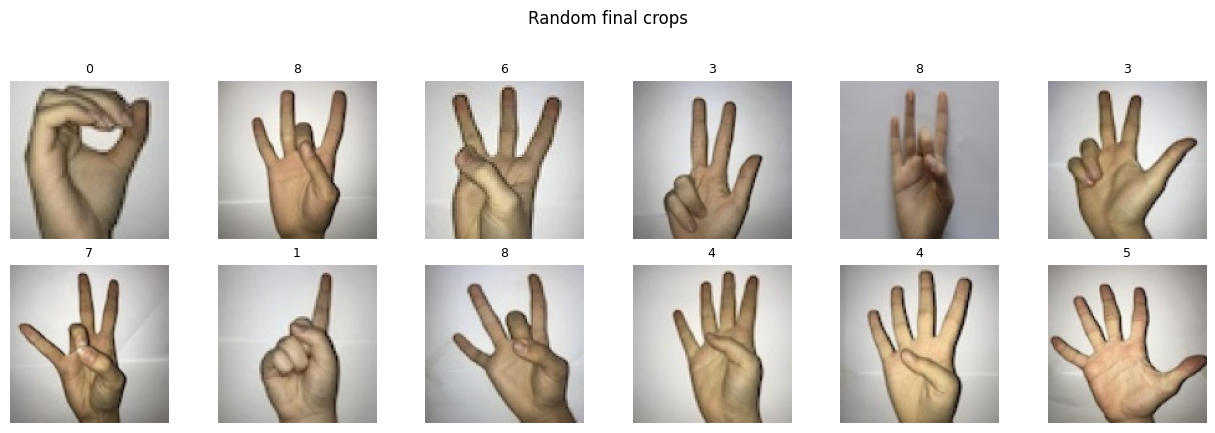

In [29]:
from pathlib import Path
import random, cv2

def show_random_crops(crops_dir, n=12, cols=6):
    """crops_dir = WORK/'crops_128' (created in your pipeline)"""
    paths = list(Path(crops_dir).rglob("*.jpg")) + list(Path(crops_dir).rglob("*.png"))
    if len(paths) == 0:
        print("No crops found at:", crops_dir); return
    random.shuffle(paths)
    paths = paths[:n]

    rows = (n + cols - 1)//cols
    plt.figure(figsize=(cols*2.1, rows*2.1))
    for i, p in enumerate(paths, 1):
        bgr = cv2.imread(str(p))
        if bgr is None: continue
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols, i)
        plt.imshow(rgb); plt.axis('off')
        plt.title(p.parent.name, fontsize=9)  # folder name = class
    plt.suptitle('Random final crops', y=1.02); plt.tight_layout(); plt.show()

show_random_crops(CROPS_DIR, n=12, cols=6)
